In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy

from optics_design_workbench import jupyter_utils

[freecad.optics_design_workbench] python package path /usr/lib/python3.13/site-packages exists on filesystem but not in sys.path, appending to sys.path...
[freecad.optics_design_workbench] python package path /usr/lib/python3.12/site-packages exists on filesystem but not in sys.path, appending to sys.path...
[freecad.optics_design_workbench] python package path /usr/lib/python3.11/site-packages exists on filesystem but not in sys.path, appending to sys.path...
PATH_TO_FREECAD_LIBDIR not specified, using default FreeCAD version in /usr/lib/freecad/lib
[Optics Design 15:10:22.358165] used module "PySide"


# Run simulations for various lens radii

In [26]:
#simulationMode = 'true'
simulationMode = 'pseudo'
#simulationMode = 'fans'

In [27]:
# prefer using this cell to open the FreeCAD Gui. This call is blocking
# until FreeCAD is closed again, which helps to avoid editing a FCStd 
# file from jupyter and the FreeCAD Gui in parallel.

#jupyter_utils.openFreecadGui()

In [28]:
# prepare arrays/lists for parameters/results
radii = linspace(36, 58, 50)
results = []

# open FCStd Document as a context manager. The context manager makes sure
# the file is closed again with certainty. Keep in mind that if the file is
# open in another FreeCAD GUI, saving from the Gui will overwrite the file
# and may leads to inconsistent file versions being seen by different 
# worker processes.
with jupyter_utils.FreecadDocument() as f:

  # setup progress tracking
  jupyter_utils.setupProgressTracker(totalSimulations=len(radii))

  # try different radii
  for rad in radii:

    # update radius and placement of both spheres that form the lens
    f.Sphere001.Radius = rad
    f.Sphere001.Placement.Base = [0, 0, -rad/1.2]
    f.Sphere.Radius = rad
    f.Sphere.Placement.Base = [0, 0, rad/1.2]

    # run a simulation
    results.append( f.runSimulation(simulationMode) )


simulation 50/50
simulations ended after 5m 35s


In [29]:
# show list of the first ten results
results[:10]

[<RawFolder simulation-run-000717/ UID=d45d07e1-4b05-42d8-9edd-bb2b97754130>,
 <RawFolder simulation-run-000718/ UID=e5e93163-0710-4bd8-a532-00532d86d0ee>,
 <RawFolder simulation-run-000719/ UID=f114ff4e-79ba-4eb4-bcbe-757ae4d8f8df>,
 <RawFolder simulation-run-000720/ UID=87e98988-0552-43fc-9fe7-c3ce1b6633ce>,
 <RawFolder simulation-run-000721/ UID=66388a14-16d6-4d59-a1d5-353f4d2ad476>,
 <RawFolder simulation-run-000722/ UID=d33ee3f4-1934-45ea-9570-5b2793ffab18>,
 <RawFolder simulation-run-000723/ UID=34748c14-d1c5-466b-b96b-2c29f8c24c0c>,
 <RawFolder simulation-run-000724/ UID=61af2e25-e587-48fd-9fa9-a86429902a6e>,
 <RawFolder simulation-run-000725/ UID=7d7c52aa-0447-4945-a0ff-1af694302c14>,
 <RawFolder simulation-run-000726/ UID=b3fe2427-7a82-4ebd-bfea-5a6c8103969d>]

In [30]:
# print filesystem tree overview of first result file:
results[0].printTree()

simulation-run-000717/
  source-OpticalPointSource/
    object-OpticalAbsorberGroup/
      <1 hit files>


# Create histograms and do Gauss fit for each histogram

In [31]:
gauss = lambda X, amp, x0, sigma: amp*exp(-(X-x0)**2/sigma**2)

In [32]:
sigmas, x0s, _Hs = [], [], []
for r in results:
  hits = r.loadHits('*')
  H, X, Y = jupyter_utils.planarHistogram(hits, bins=(300, 301), XY='centers') #XY='edges')

  #figure(figsize=(4,4))
  #pcolormesh(X, Y, H.T)
  #show()
  
  #figure(figsize=(4,4))
  _H = H.sum(axis=1)
  #plot(X, _H)
  try:
    (amp, x0, sigma), _ = scipy.optimize.curve_fit(gauss, X, _H, p0=(max(_H), 0, 1))
  except Exception:
    amp, x0, sigma = nan, nan, nan
  #plot(X, gauss(X, amp, x0, sigma))
  #show()

  sigmas.append(sigma)
  x0s.append(x0)
  _Hs.append(_H)

Text(0, 0.5, 'lens radius')

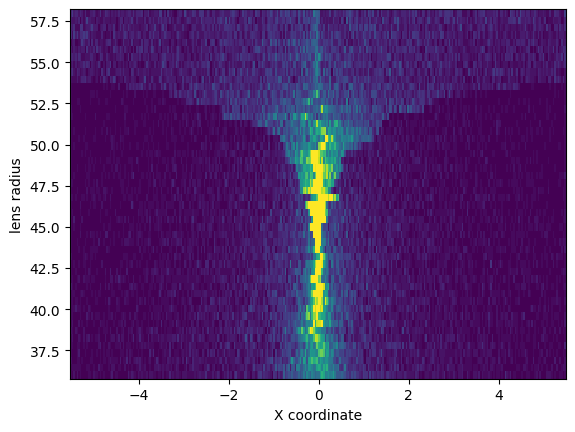

In [33]:
import matplotlib.colors as col
_Hs = array(_Hs)
pcolormesh(X, radii, _Hs, norm=col.Normalize(_Hs.min(), _Hs.max()/5, clip=True))
xlabel('X coordinate')
ylabel('lens radius')

[]

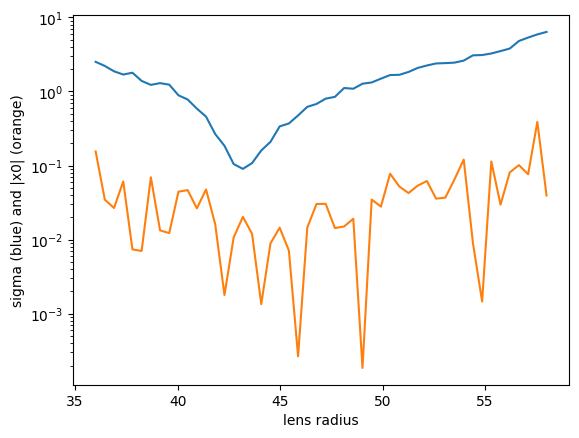

In [34]:
plot(radii, sigmas)
plot(radii, abs(x0s))
xlabel('lens radius')
ylabel('sigma (blue) and |x0| (orange)')
semilogy()